In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, accuracy_score

# Load Model

In [ ]:
# Load best_params.json
try:
  with open('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/best_params.json') as f:
      data = json.load(f)
      best_item = max(data, key=lambda x: x['val_acc'])
      best_params = best_item['params']
except Exception as e:
    print("Gagal membaca best_params.json:", e)
    exit(1)

In [ ]:
# Inisialisasi class BiGRU
class BiGRUModel(nn.Module):
    def __init__(self, units):
        super(BiGRUModel, self).__init__()
        self.gru = nn.GRU(input_size=768, hidden_size=units, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(units * 2, 9)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, h = self.gru(x)
        h_concat = torch.cat((h[0], h[1]), dim=1)
        out = self.fc(h_concat)
        return self.sigmoid(out)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = BiGRUModel(best_params['units'])
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/Bi-GRU.pt', map_location=device))

<All keys matched successfully>

In [ ]:
X = np.load('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/bert_embedding.npy')
y_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/preprocessed_data.csv')
y = y_df.drop(columns=['Tweet']).values

In [ ]:
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=best_params['batch_size'])

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)

    criterion = nn.BCELoss()
    test_losses = []
    test_accs = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).squeeze()
            loss = criterion(preds, yb.float())
            test_losses.append(loss.item())
            preds_binary = (preds > 0.5).float()
            acc = (preds_binary == yb).float().mean().item()
            test_accs.append(acc)

    mean_loss = np.mean(test_losses)
    mean_acc = np.mean(test_accs)

    print(f"Test Accuracy: {mean_acc:.4f}")
    print(f"Test Loss: {mean_loss:.4f}")

    return mean_loss, mean_acc


In [ ]:
def get_preds_and_targets(model, dataloader, device):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            preds = model(xb).cpu()
            preds_binary = (preds > 0.5).float()
            all_preds.append(preds_binary)
            all_targets.append(yb)

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()
    return y_pred, y_true

In [ ]:
def generate_confusion_matrices(model, test_loader, label_names, device):
    y_pred, y_true = get_preds_and_targets(model, test_loader, device)
    cms = multilabel_confusion_matrix(y_true, y_pred)

    num_labels = len(label_names)
    cols = 3
    rows = math.ceil(num_labels / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 4.5))
    axes = axes.flatten() if num_labels > 1 else [axes]

    for i, label in enumerate(label_names):
        cm = cms[i]
        ax = axes[i]
        cm_flipped = cm[::-1, ::-1]

        sns.heatmap(cm_flipped, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pos', 'Neg'], yticklabels=['Pos', 'Neg'], ax=ax)
        ax.set_title(f'{label}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    for j in range(len(label_names), len(axes)):
        fig.delaxes(axes[j])

    fig.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.show()

    return cms


In [ ]:
def generate_classification_report(model, test_loader, label_names, device):
    y_pred, y_true = get_preds_and_targets(model, test_loader, device)

    recalls = recall_score(y_true, y_pred, average=None, zero_division=0)
    precisions = precision_score(y_true, y_pred, average=None, zero_division=0)
    accuracies = []

    cms = multilabel_confusion_matrix(y_true, y_pred)
    for cm in cms:
        tn, fp, fn, tp = cm.ravel()
        acc = (tp + tn) / (tp + tn + fp + fn)
        accuracies.append(acc)

    avg_accuracy = np.mean(accuracies)
    avg_recall = np.mean(recalls)
    avg_precision = np.mean(precisions)

    print(f"\n{'Label':<15} {'Accuracy':<10} {'Recall':<10} {'Precision':<10}")
    print("-" * 45)
    for i in range(len(label_names)):
        print(f"{label_names[i]:<15} {accuracies[i]:<10.4f} {recalls[i]:<10.4f} {precisions[i]:<10.4f}")
    print("-" * 45)
    print(f"{'average':<15} {avg_accuracy:<10.4f} {avg_recall:<10.4f} {avg_precision:<10.4f}")


In [ ]:
# def evaluate_model(model, dataloader, device):
#     model.eval()
#     model.to(device)

#     test_losses = []
#     test_accs = []

#     with torch.no_grad():
#         for xb, yb in dataloader:
#             xb, yb = xb.to(device), yb.to(device)
#             preds = model(xb).squeeze()
#             loss = nn.BCELoss(preds, yb.float())
#             test_losses.append(loss.item())
#             preds_binary = (preds > 0.5).float()
#             acc = (preds_binary == yb).float().mean().item()
#             test_accs.append(acc)

#     mean_loss = np.mean(test_losses)
#     mean_acc = np.mean(test_accs)

#     print(f"Test Accuracy: {mean_acc:.4f}")
#     print(f"Test Loss: {mean_loss:.4f}")

#     return mean_loss, mean_acc

# def generate_confusion_matrices(model, test_loader, label_names, device):
#     model.eval()
#     model.to(device)

#     all_preds = []
#     all_targets = []

#     with torch.no_grad():
#         for xb, yb in test_loader:
#             xb = xb.to(device)
#             preds = model(xb).cpu()
#             preds_binary = (preds > 0.5).float()
#             all_preds.append(preds_binary)
#             all_targets.append(yb)

#     y_pred = torch.cat(all_preds).numpy()
#     y_true = torch.cat(all_targets).numpy()

#     cms = multilabel_confusion_matrix(y_true, y_pred)

#     num_labels = len(label_names)
#     cols = 3
#     rows = math.ceil(num_labels / cols)

#     fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 4.5))
#     axes = axes.flatten() if num_labels > 1 else [axes]

#     for i, label in enumerate(label_names):
#         cm = cms[i]
#         ax = axes[i]

#         # Balik baris dan kolom confusion matrix
#         cm_flipped = cm[::-1, ::-1]

#         sns.heatmap(cm_flipped, annot=True, fmt='d', cmap='Blues', cbar=False,
#                     xticklabels=['Pos', 'Neg'], yticklabels=['Pos', 'Neg'], ax=ax)
#         ax.set_title(f'{label}')
#         ax.set_xlabel('Predicted')
#         ax.set_ylabel('Actual')

#     for j in range(len(label_names), len(axes)):
#         fig.delaxes(axes[j])

#     fig.subplots_adjust(wspace=0.4, hspace=0.6)
#     plt.show()

#     return cms

# def generate_classification_report(model, test_loader, label_names, device):
#     model.eval()
#     model.to(device)

#     all_preds = []
#     all_targets = []

#     with torch.no_grad():
#         for xb, yb in test_loader:
#             xb = xb.to(device)
#             preds = model(xb).cpu()
#             preds_binary = (preds > 0.5).float()
#             all_preds.append(preds_binary)
#             all_targets.append(yb)

#     y_pred = torch.cat(all_preds).numpy()
#     y_true = torch.cat(all_targets).numpy()

#     recalls = recall_score(y_true, y_pred, average=None, zero_division=0)
#     precisions = precision_score(y_true, y_pred, average=None, zero_division=0)
#     accuracies = []

#     for i in range(len(label_names)):
#         cm = multilabel_confusion_matrix(y_true, y_pred)[i]
#         tn, fp, fn, tp = cm.ravel()
#         acc = (tp + tn) / (tp + tn + fp + fn)
#         accuracies.append(acc)

#     # Hitung rata-rata (macro average)
#     avg_accuracy = np.mean(accuracies)
#     avg_recall = np.mean(recalls)
#     avg_precision = np.mean(precisions)

#     # Tampilkan hasil evaluasi
#     print(f"\n{'Label':<15} {'Accuracy':<10} {'Recall':<10} {'Precision':<10}")
#     print("-" * 45)
#     for i in range(len(label_names)):
#         print(f"{label_names[i]:<15} {accuracies[i]:<10.4f} {recalls[i]:<10.4f} {precisions[i]:<10.4f}")
#     print("-" * 45)
#     print(f"{'average':<15} {avg_accuracy:<10.4f} {avg_recall:<10.4f} {avg_precision:<10.4f}")


In [ ]:
# inisialisasi label_names
label_names = y_df.drop(columns=['Tweet']).columns.tolist()

In [ ]:
# Konversi y_test (NumPy array) ke DataFrame
y_test_df = pd.DataFrame(y_test, columns=label_names)

# Hitung jumlah 1 dan 0 untuk tiap label
label_counts = y_test_df.apply(lambda col: pd.Series({
    'Positive (1)': (col == 1).sum(),
    'Negative (0)': (col == 0).sum()
}))

# Transpose agar rapi
label_counts = label_counts.T

# Tambahkan kolom Total
label_counts['Total'] = label_counts['Positive (1)'] + label_counts['Negative (0)']

# Tampilkan
print(label_counts)

               Positive (1)  Negative (0)  Total
HS                     1084          1509   2593
Abusive                 978          1615   2593
HS_Individual           712          1881   2593
HS_Group                372          2221   2593
HS_Religion             124          2469   2593
HS_Race                 136          2457   2593
HS_Physical              54          2539   2593
HS_Gender                60          2533   2593
HS_Other                742          1851   2593


Test Accuracy: 0.9580
Test Loss: 0.1437


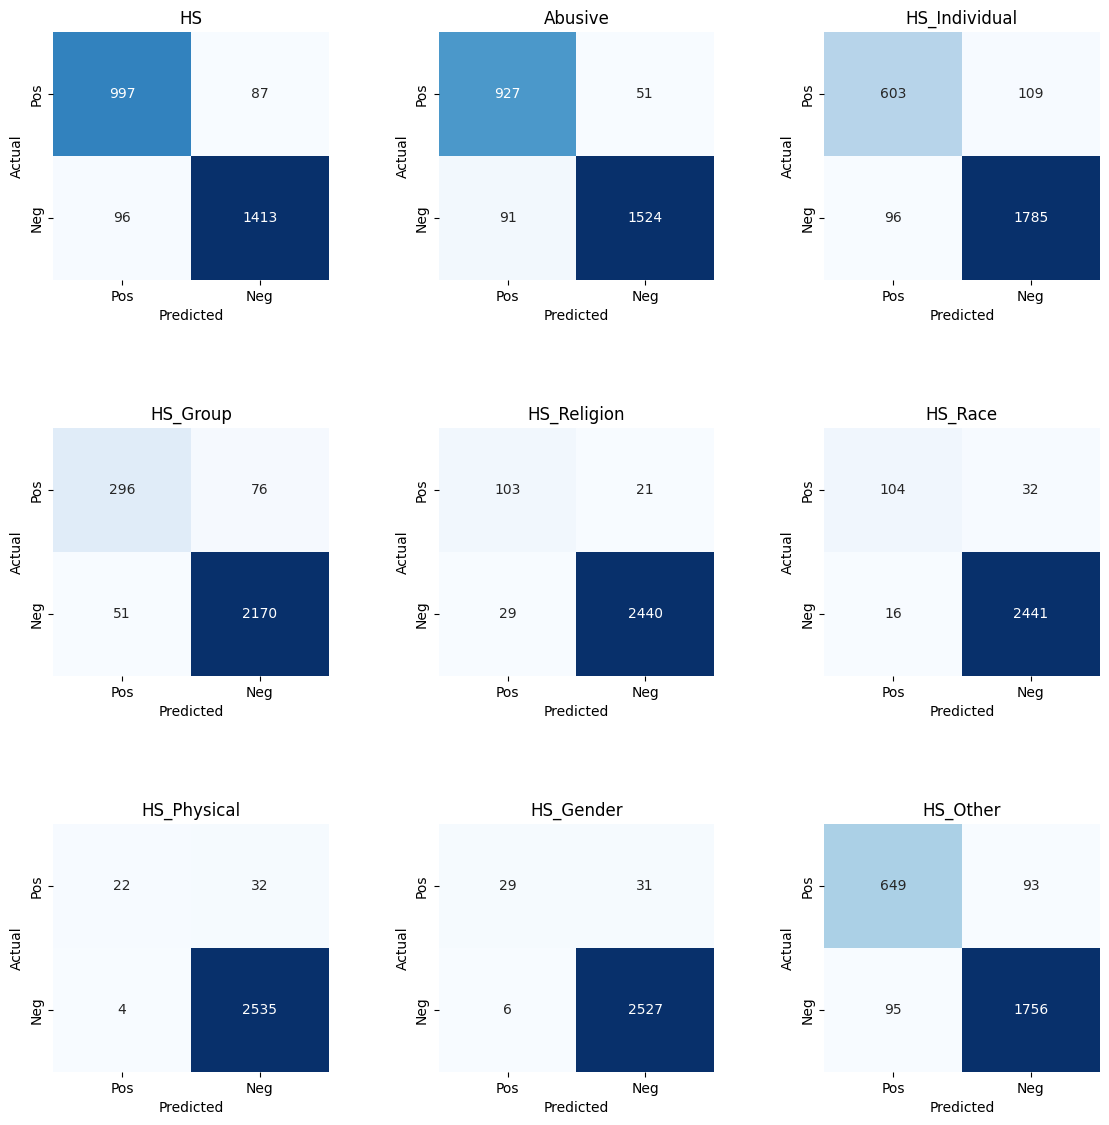


Label           Accuracy   Recall     Precision 
---------------------------------------------
HS              0.9294     0.9197     0.9122    
Abusive         0.9452     0.9479     0.9106    
HS_Individual   0.9209     0.8469     0.8627    
HS_Group        0.9510     0.7957     0.8530    
HS_Religion     0.9807     0.8306     0.7803    
HS_Race         0.9815     0.7647     0.8667    
HS_Physical     0.9861     0.4074     0.8462    
HS_Gender       0.9857     0.4833     0.8286    
HS_Other        0.9275     0.8747     0.8723    
---------------------------------------------
average         0.9565     0.7634     0.8592    


In [ ]:
# Evaluasi
evaluate_model(model, test_loader, device)
generate_confusion_matrices(model, test_loader, label_names, device)
generate_classification_report(model, test_loader, label_names, device)